In [0]:
import numpy as np

In [0]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


# 의류 이미지를 분류 합니다.

앞에서 만든 Multiclassnetwork 클래스를 사용하여 '의류 이미지 분류하기'라는 다중 분류 문제를 해결 해 보겠습니다. 이번 실습 부터는 패션 MNIST 데이터를 텐서플로에서 불러와 사용합니다.

### 1.텐서플로 설치 및 임포트 하기

In [60]:
!pip install tensorflow-gpu==2.0.0-rc1 # 구글 콜렙은 1.15버전이라 2.0 버전으로 업그레이드 해야합니다

In [0]:
import tensorflow as tf

### 2.텐서플로 버전 확인하기

In [62]:
tf.__version__

'2.0.0-rc1'

### 3.패션 MNIST데이터 세트 불러오기

In [0]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

### 4.훈련 세트의 크기 확인하기

In [64]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


<img src="https://github.com/legi1993/eee/blob/master/1573815886230-16ababb7-de49-445a-b137-7c8f5e72ae83_.jpg?raw=true" width="40%">

### 5.imgshow()함수로 샘플 이미지 확인하기

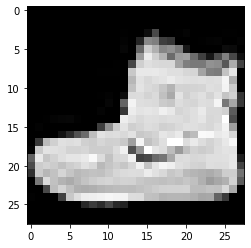

In [65]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray') # imshow() 함수는 넘파이 배열을 받아 이미지를 그리는데 cmap='gray' 이므로 배열 원소값이 0에 가까울수록 검게 그려집니다
plt.show()

### 6.타깃의 내용과 의미 확인하기

타깃의 크기는 60,000개의 요소를 가진 1차원 배열인데 이중 가장 앞에 있는 데이터 10개만 출력해보겠습니다

In [66]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [0]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
# 순서대로 0부터 9까지의 의미 

In [68]:
print(class_names[y_train_all[0]])

앵클부츠


### 7.타깃 분포 확인하기

훈련 세트와 검증 세트로 나누기 전 훈련 세트의 타깃값들이 고르게 분포되어있는지 확인해보겠습니다

In [69]:
np.bincount(y_train_all)  # 배열에 있는 정수값의 등장 횟수를 세어 정수값에 해당하는 인덱스 위치에 저장합니다

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

###8.훈련 세트와 검증 세트 고르게 나누기

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

검증 세트의 레이블이 잘 나눠졌는지 확인

In [72]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [73]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

### 9.입력 데이터 정규화 하기

이미지 데이터는 픽셀마다 0 ~ 255사이 값을 가지므로 255로 나누어 0~1 사이로 맞춥니다

In [0]:
x_train = x_train / 255
x_val = x_val / 255

### 10.훈련세트와 검증세트의 차원 변경하기

기존 28 * 28 크기의 2차원 배열을 reshape() 메서드를 사용하여 1차원 배열의 샘플로 바꿉니다

In [0]:
x_train = x_train.reshape(-1, 784) # (-1,784)는 784열로 맞춘다는 뜻이다
x_val = x_val.reshape(-1, 784)

In [76]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


![대체 텍스트](https://github.com/JungMinNoh/jungminnoh/blob/master/7-8.jpg?raw=true)

###타깃 데이터를 준비하고 다중 분류 신경망을 훈련합니다

MNIST 데이터세트는 10개의 클래스로 구성되어 있으므로 출력 뉴런의 개수도 10개가 되어야 합니다. 하지만 y_train, y_val에 저장된 값들은 0 ~ 9 사이의 정수값 하나로 10개의 출력 뉴런에 대응되지 않습니다. 즉, 이 타깃 데이터를 출력 뉴런의 갯수에 맞게 변형해야 합니다.

### 1. 타깃을 원-핫 인코딩(one-hot encoding)으로 변환하기 

정수값에 해당하는 원소는 1, 나머지 원소는 0으로 하여 10개의 원소를 가진 배열을 만드는 것입니다. 

![대체 텍스트](https://lh3.googleusercontent.com/uWKy_lt7XFZ4LXwmno2FJG55doPC3TInc8S2HOFB3vkOXMIdYbKKVYlbYqWlVkrdMB3ecSP53jd3FJRC8wmhxdH3j8k3vz8Aib6wN-RTnJWbKG7JGVvrhrD2qaafBR0fj56frHz_SVKjr89rTgCIK3nSNu6PpRDHynLgtOPlHnVfXKShR91hvGO8NfcmBlp_MxsiDTWs7H9hz9SZWYI2U5BKSGiz-e6-Rrereq3Hng2zGMS6x1ot9ez7zjSNrA23WqSHw78ZzHgImhGbH2Lk50E_sgOmhTalx9kJjRM3PAnr_XQlRcciM-Xhsx13jHbEpz2b7Ynjd_X69iqtpCdeWh4zqaQ0HMN0-2K1eEVtKbcH0wkVyNX4kuY4u8hT6dHZox2u77h3MUNYI90p3TH0qaeyBJzpVpma5PfPVmivfxDRykmz4sLd16d_0mMJqFMiYeF1DxjpuRaGEH4IOCdspolkxm5wU59DkVEh0LDc6MsjkeycR37TJH3IQsUJOs9ETyWaJCMuNrmoRIp8ySvLuP0zkgM6B4OBq_rRR1V8uN0hzCTpZlvkS5MVpAsMb57s9wYf7g6OpT-1Dhmk1Zaaer1yjd_9WFob8cxlX803hI200ZR0_Vy7NeOnZ0XdKKrRNO59D8jrU3VvWmiepUKUhOrJ_jvjt1c5vebxASbVMvmO0Cg5=w834-h625-no)

![대체 텍스트](https://lh3.googleusercontent.com/gW1mxY5yGXqeyWnXv-ydwiJKOlUAfy5WpbVTly12yj3jsqqPYOf7vjjqEtzgt1j2AEpOs4WXSNJfhf1DnlzdJ3vnWfO3X1zsTxcJgSCD0nssCCRbLne3nuXuTO6ifpw8qmSqVZEg8DG3EgTEDIWJueIPF1n8wfEcXUqyRPaw2R5S1SuCMIjwa3OmE6YU9wpPyS1PVu_9Jn_-Q4x86KuCl9c1yIp9dzXgKCUjvF2ISDFRPmldpAAHcipkmfaO4UD7FFDViUMq8107cKd_ZH_xELVuVjxJ9ozd6XK4fRKL9zIWbJLIsIFcn6eauOp8p2qgwFr5fF3gO8s22bgQtNmyjmd7ywkJsjq0kvf0yR3A-7SP8SgkqxMVOUkKSS2qRwCGIpq3JxMRn9IvNpN_Hyxg3oRsnm2Tg0pchvRioZ7lRigWRcv6_HRc_b6zBsnDAaIW4DYiVB-PsxGQeQMGHHWLoNkXL7-vmgHqsiXlubnSNmNH9q5JH3Y8mnZa6TI-f_tw4BXrtyrFek4IpL1Nvtqxmd0dpfTNfpDg8YkqXkK8pHI47wz7gjWfvADjSTdgAbHUgvNtZvVbXIBcDZ1GrH0Qifhq0zl-Z_Hq5TRY7T5rH0RQ5zDlQWF6MFBBqoeYrGxOyBmzYsVLOHPJRSuSMMUppXdLnUpxWulzcEOtOPuSXrhij1gb=w834-h625-no)

###3. to_catagorical 함수 사용해 원-핫 인코딩하기


In [77]:
tf.keras.utils.to_categorical([0,1,3]) # 1행은 0, 2행은 1, 3행은 3에 해당하는 값

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [0]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [79]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [80]:
print(y_train[0], y_train_encoded[0]) # 0~9까지 나타낸다

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


###4. MultiClassNetwork 클래스로 다중 분류 신경망 훈련하기


In [81]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

###5. 훈련 손실, 검증 손실 그래프와 훈련 모델 점수 확인하기

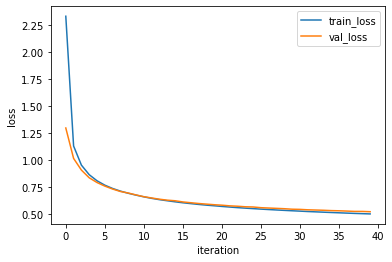

In [82]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [83]:
fc.score(x_val, y_val_encoded)

0.8150833333333334